Для начала импортируем нужные для дальнейшей работы библиотеки:

In [1]:
import random as rnd
import matplotlib.pyplot as plt

Объявим несколько констант и переменных для алгоритма обучения с подкреплением (Q-Learning):<br>
GLASSES_COUNT – количество объектов стаканов, используемых в задаче.<br>
ORDER – максимальное количество миллилитров компота, которое может быть в стакане.<br>
NUM_EPISODES – количество итераций для тренировки модели.<br>
ALPHA – коэффициент обучения (learning rate), который регулирует скорость обновления весов модели.<br>
GAMMA – фактор дисконтирования (discount factor), определяющий важность будущих вознаграждений относительно текущих.<br>
Q – пустой словарь, который будет использоваться для хранения таблицы Q-значений, где хранятся оценки действий агента в различных условиях.<br>

In [2]:
GLASSES_COUNT = 5
ORDER = 10
NUM_EPISODES = 2000
ALPHA = 0.8
GAMMA = 0.95
Q = {}

Создается список g, который будет представлять собой начальное распределение компота по стаканам. Добавим условие: если сумма всех элементов списка g не делится нацело на количество стаканов, то одному из стаканов добавляется недостающее значение, чтобы сумма стала кратной количеству стаканов.

In [15]:
def init_glasses():
    g = []
    for _ in range(GLASSES_COUNT):
        g.append(rnd.randint(1, ORDER))
    if sum(g) % GLASSES_COUNT != 0:
        g[rnd.randint(0, GLASSES_COUNT-1)] += GLASSES_COUNT - (sum(g) % GLASSES_COUNT)
    return g

INITIAL_GLASSES = init_glasses()

print("Изначальное состояние стаканов:", INITIAL_GLASSES)

Изначальное состояние стаканов: [3, 8, 8, 7, 9]


Реализуем Q-обучение. Для этого нам понадобяться функции:<br>
state_to_string – преобразует текущее состояние стаканов (список чисел) в строку для использования в качестве ключа в таблице Q.<br>
action_to_string – преобразует действие (кортеж из трех элементов) в строку для использования в таблице Q.<br>
describe_action – возвращает строковое описание действия агента (переливание жидкости между стаканами).<br>
is_equal – проверяет, равны ли уровни жидкости во всех стаканах.<br>
choose_random_action – выбирает случайное действие (из какого стакана взять жидкость, куда перелить и сколько перелить).<br>
pour_compote – выполняет действие по переливанию жидкости из одного стакана в другой.<br>
get_all_actions – генерирует все возможные действия для текущего состояния стаканов.<br>
choose_action – выбирает оптимальное действие на основе текущей таблицы Q. Если оптимального действия нет, выбирает случайное.<br>
update_Q – обновляет таблицу Q на основе полученного вознаграждения и нового состояния после выполнения действия.<br>
perform_actions – основной цикл выполнения действий. Агент выполняет действия до тех пор, пока уровни жидкости в стаканах не станут равными.<br>

In [6]:
glasses = INITIAL_GLASSES

def state_to_string(state):
    _t = ""
    for s in state:
        _t += f'-{s}'
    return _t[1:]

def action_to_string(action):
    return f'{action[0]}/{action[1]}/{action[2]}'

def describe_action(action):
    return f'Агент переливает {action[2]} мл. компота из стакана № {action[0]+1} в стакан № {action[1]+1}'

def is_equal(glasses):
    for i in range(len(glasses)-1):
        if glasses[i] != glasses[i+1]:
            return False
    return True

def choose_random_action(glasses):
    glass_from = rnd.randint(0, GLASSES_COUNT-1)
    if glasses[glass_from] == 0:
        return choose_random_action(glasses)
    glass_to = rnd.randint(0, GLASSES_COUNT-2)
    if glass_to >= glass_from:
        glass_to += 1
    glass_compote = rnd.randint(1, glasses[glass_from])
    return (glass_from, glass_to, glass_compote)

def pour_compote(ogl, instruction):
    gl = ogl.copy()
    if gl[instruction[0]] >= instruction[2]:
        gl[instruction[0]] -= instruction[2]
        gl[instruction[1]] += instruction[2]
    return gl

def get_all_actions(glasses):
    actions = []
    for i in range(0, len(glasses)):
        for j in range(0, len(glasses)):
            if i == j:
                continue
            for k in range(1, glasses[i]+1):
                actions.append(action_to_string((i, j, k)))
    return actions

def choose_action(glasses):
    state = state_to_string(glasses)
    if state not in Q:
        return choose_random_action(glasses)
    
    max_value = max(Q[state].values())
    best_actions = [action for action, value in Q[state].items() if value == max_value]
    choice = rnd.choice(best_actions)
    return (int(choice.split("/")[0]), int(choice.split("/")[1]), int(choice.split("/")[2]))

def update_Q(glasses, action, reward, next_glasses):
    state = state_to_string(glasses)
    next_state = state_to_string(next_glasses)
    if state not in Q:
        Q[state] = {}
        for a in get_all_actions(glasses):
            Q[state][a] = 0

    if next_state not in Q:
        Q[next_state] = {}
        for a in get_all_actions(next_glasses):
            Q[next_state][a] = 0

    Q[state][action] = Q[state][action] + ALPHA * (reward + GAMMA * max(Q[next_state].values()) - Q[state][action])

def perform_actions(describe = False, random_initial = False):
    glasses = []
    if random_initial:
        glasses = init_glasses()
    else:
        glasses = INITIAL_GLASSES.copy()
    at = 0
    while not is_equal(glasses):
        at += 1
        if describe:
            print(f"{at}. Состояние стаканов:", glasses)
        action = choose_action(glasses)
        if describe:
            print(describe_action(action))
        new_glasses = pour_compote(glasses, action)
        update_Q(glasses, action_to_string(action), -1, new_glasses)
        glasses = new_glasses.copy()
    if describe:
        print(f"{at+1}. Состояние стаканов:", glasses)
        print(f"Стаканы уравновешены")
    return at

Научим агента решать задачу при исходном состоянии, полученном ранее.
В цикле агент проходит определенное количество итераций обучения. На каждой итерации вызывается функция perform_actions, которая возвращает количество шагов, необходимых для достижения цели (уравновесить уровень жидкости в стаканах). Каждые 100 шагов выводится сообщение о текущем прогрессе. После количество шагов преобразуется в штраф -at и заносится в список rewards_history.
После завершения всех итераций строится кривая обучения.

Прогоны 1-100
Прогоны 101-200
Прогоны 201-300
Прогоны 301-400
Прогоны 401-500
Прогоны 501-600
Прогоны 601-700
Прогоны 701-800
Прогоны 801-900
Прогоны 901-1000
Прогоны 1001-1100
Прогоны 1101-1200
Прогоны 1201-1300
Прогоны 1301-1400
Прогоны 1401-1500
Прогоны 1501-1600
Прогоны 1601-1700
Прогоны 1701-1800
Прогоны 1801-1900
Прогоны 1901-2000


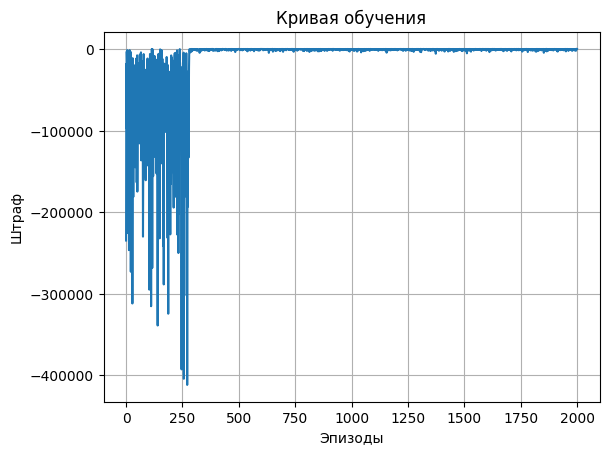

In [16]:
rewards_history = []
for ep in range(NUM_EPISODES):
    at = perform_actions(False, False)
    if ep % 100 == 0:
        print(f"Прогоны {ep+1}-{ep+100}")
    rewards_history.append(-at)

plt.plot(rewards_history)
plt.xlabel('Эпизоды')
plt.ylabel('Штраф')
plt.title('Кривая обучения')
plt.grid(True)
plt.show()

Рассмотрим поближе отрезок, где происходило обучение агента.

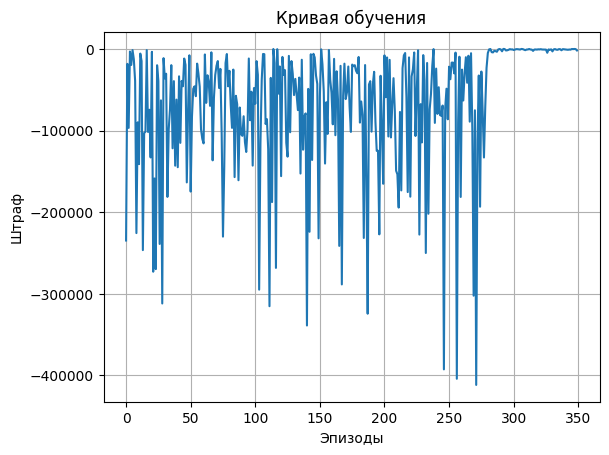

In [18]:
plt.plot(rewards_history[0:350])
plt.xlabel('Эпизоды')
plt.ylabel('Штраф')
plt.title('Кривая обучения')
plt.grid(True)
plt.show()

Рассмотрим производимые в ходе обучения агентом действия.

In [19]:
perform_actions(True, False)

1. Состояние стаканов: [3, 8, 8, 7, 9]
Агент переливает 5 мл. компота из стакана № 4 в стакан № 5
2. Состояние стаканов: [3, 8, 8, 2, 14]
Агент переливает 10 мл. компота из стакана № 5 в стакан № 3
3. Состояние стаканов: [3, 8, 18, 2, 4]
Агент переливает 10 мл. компота из стакана № 3 в стакан № 2
4. Состояние стаканов: [3, 18, 8, 2, 4]
Агент переливает 2 мл. компота из стакана № 3 в стакан № 2
5. Состояние стаканов: [3, 20, 6, 2, 4]
Агент переливает 3 мл. компота из стакана № 2 в стакан № 5
6. Состояние стаканов: [3, 17, 6, 2, 7]
Агент переливает 6 мл. компота из стакана № 2 в стакан № 5
7. Состояние стаканов: [3, 11, 6, 2, 13]
Агент переливает 10 мл. компота из стакана № 5 в стакан № 1
8. Состояние стаканов: [13, 11, 6, 2, 3]
Агент переливает 8 мл. компота из стакана № 1 в стакан № 4
9. Состояние стаканов: [5, 11, 6, 10, 3]
Агент переливает 5 мл. компота из стакана № 1 в стакан № 5
10. Состояние стаканов: [0, 11, 6, 10, 8]
Агент переливает 1 мл. компота из стакана № 5 в стакан № 1
11.

589

Рассмотрим, какое получилось среднее количество, минимум и максимум переливаний для обучения агента на заданных начальных данных.

In [20]:
total_moves = 0
min_moves = 999999
max_moves = 0
experiments = 100
for i in range(experiments):
    moves = perform_actions(False, True)
    total_moves += moves
    if moves < min_moves:
        min_moves = moves
    if moves > max_moves:
        max_moves = moves
print(f"Среднее количество переливаний: {total_moves / experiments}")
print(f"Минимум переливаний: {min_moves}")
print(f"Максимум переливаний: {max_moves}")

Среднее количество переливаний: 42998.88
Минимум переливаний: 1
Максимум переливаний: 699632


Повторим обучение агента на новом наборе входных данных:

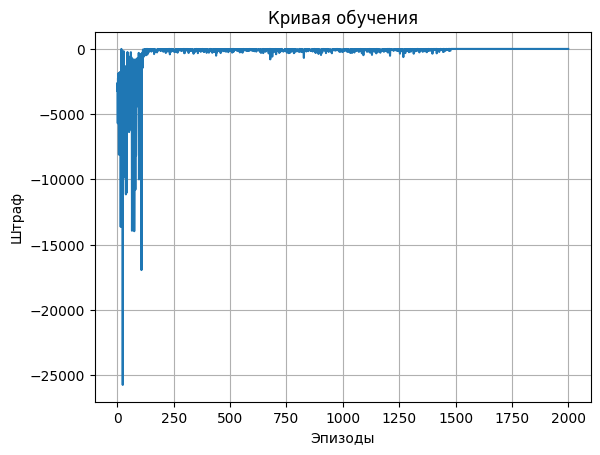

1. Состояние стаканов: [2, 4, 6, 2, 1]
Агент переливает 1 мл. компота из стакана № 2 в стакан № 1
2. Состояние стаканов: [3, 3, 6, 2, 1]
Агент переливает 3 мл. компота из стакана № 3 в стакан № 5
3. Состояние стаканов: [3, 3, 3, 2, 4]
Агент переливает 1 мл. компота из стакана № 5 в стакан № 4
4. Состояние стаканов: [3, 3, 3, 3, 3]
Стаканы уравновешены
Среднее количество переливаний: 105804.86
Минимум переливаний: 1
Максимум переливаний: 768324


In [24]:
INITIAL_GLASSES = init_glasses()

rewards_history = []
for ep in range(NUM_EPISODES):
    at = perform_actions(False, False)
    rewards_history.append(-at)

plt.plot(rewards_history)
plt.xlabel('Эпизоды')
plt.ylabel('Штраф')
plt.title('Кривая обучения')
plt.grid(True)
plt.show()

perform_actions(True, False)

for i in range(experiments):
    moves = perform_actions(False, True)
    total_moves += moves
    if moves < min_moves:
        min_moves = moves
    if moves > max_moves:
        max_moves = moves
print(f"Среднее количество переливаний: {total_moves / experiments}")
print(f"Минимум переливаний: {min_moves}")
print(f"Максимум переливаний: {max_moves}")

И запустим обучение на ещё одном наборе данных:

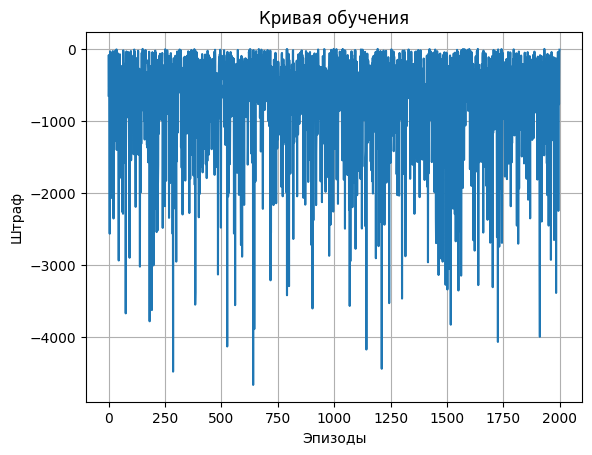

1. Состояние стаканов: [4, 10, 3, 10, 8]
Агент переливает 4 мл. компота из стакана № 1 в стакан № 3
2. Состояние стаканов: [0, 10, 7, 10, 8]
Агент переливает 1 мл. компота из стакана № 4 в стакан № 2
3. Состояние стаканов: [0, 11, 7, 9, 8]
Агент переливает 4 мл. компота из стакана № 5 в стакан № 1
4. Состояние стаканов: [4, 11, 7, 9, 4]
Агент переливает 4 мл. компота из стакана № 4 в стакан № 2
5. Состояние стаканов: [4, 15, 7, 5, 4]
Агент переливает 11 мл. компота из стакана № 2 в стакан № 4
6. Состояние стаканов: [4, 4, 7, 16, 4]
Агент переливает 2 мл. компота из стакана № 4 в стакан № 3
7. Состояние стаканов: [4, 4, 9, 14, 4]
Агент переливает 1 мл. компота из стакана № 4 в стакан № 1
8. Состояние стаканов: [5, 4, 9, 13, 4]
Агент переливает 3 мл. компота из стакана № 5 в стакан № 1
9. Состояние стаканов: [8, 4, 9, 13, 1]
Агент переливает 6 мл. компота из стакана № 1 в стакан № 4
10. Состояние стаканов: [2, 4, 9, 19, 1]
Агент переливает 1 мл. компота из стакана № 5 в стакан № 2
11. Со

In [25]:
INITIAL_GLASSES = init_glasses()

rewards_history = []
for ep in range(NUM_EPISODES):
    at = perform_actions(False, False)
    rewards_history.append(-at)

plt.plot(rewards_history)
plt.xlabel('Эпизоды')
plt.ylabel('Штраф')
plt.title('Кривая обучения')
plt.grid(True)
plt.show()

perform_actions(True, False)

for i in range(experiments):
    moves = perform_actions(False, True)
    total_moves += moves
    if moves < min_moves:
        min_moves = moves
    if moves > max_moves:
        max_moves = moves
print(f"Среднее количество переливаний: {total_moves / experiments}")
print(f"Минимум переливаний: {min_moves}")
print(f"Максимум переливаний: {max_moves}")

Итоги:  
1) Как видно из эксперементов, агент, по большей части, научился сливать компот в один стакан, а затем сводить выполнение задачи к одному из известных ему вариантов решения.
2) Минимальное среднее количество переливаний составляет 42999.
3) Минимум переливаний составляет 1.
4) Максимум переливаний составляет 768324.